In [162]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import datetime as dt
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline 

# Steps:
1. Read and understand the data
2. Clean the data
3. Preparatino of data 
4. Modelling 
5. Analysis and Business Recommendation


### 1. Read and understand the data

In [163]:
# Checking encoding type 
# import chardet
# with open('Online+Retail.csv','rb') as rawdata:
#     charType = chardet.detect(rawdata.read())

# print(charType)

In [164]:
# ISO-8859-1 is able to decode the dataset
df = pd.read_csv('Online+Retail.csv',encoding='ISO-8859-1')
df.shape

(541909, 8)

In [165]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom


In [166]:
df.tail(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,09-12-2011 12:50,4.95,12680.0,France


In [167]:
df.info()
# we have missing values in 'Description' and 'CustomerID'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### 2. Cleaning the data 

In [168]:
# missing values 
round((df.isnull().sum() / df.shape[0]) * 100,2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [169]:
# Drop all rows containing null values
print('Total row before dropping',df.shape[0])
df = df.dropna()
print('Total row after dropping',df.shape[0])

Total row before dropping 541909
Total row after dropping 406829


In [170]:
# creat new column for total amount 
df['amount'] = df.Quantity * df.UnitPrice

### 3. Prepare the data for modelling

- R : (Recency ) > How recently was last transcation done
- F : (Frequency) > Frequency of tansaction last year
- M : (Monetory) > Total amount of revenure contributed by the customer

#### we have to convert our data columns into the following columns
For above dataset columns we required is 
-> 'cust_id', 'recency' , 'frequency' , 'monetory'

In [171]:
# Creating monetory column 
gm = df.groupby('CustomerID')['amount'].agg('sum')
gm = gm.reset_index()

In [172]:
# Frequency 
gf = df.groupby('CustomerID')['InvoiceNo'].agg('count')
gf = gf.reset_index()
gf.columns = ['CustomerID','Frequency']

In [173]:
# Merge both dataframe 
gf = pd.merge(left = gm,right = gf,on='CustomerID',how='inner')

In [174]:
gf.head(3)

,CustomerID,amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31


In [175]:
# Creating Recency  Column

# compute number of days since last transaction 
# 1. Convert 'InvoiceDate' column to DateTime object 
df.InvoiceDate =  pd.to_datetime(df.InvoiceDate,format='%d-%m-%Y %H:%M')
# 2. Compute max date
max_date = max(df.InvoiceDate)
# 3. Compute diffrence between maximum date and actual invoice date
df['diff'] = max_date  - df.InvoiceDate
# 4. group by csutomerID and find min value of diff
gr = df.groupby('CustomerID')['diff'].agg('min')
gr.reset_index()
# 5. Merge it with gf on customerID 
gf = pd.merge(left=gf,right=gr,on='CustomerID',how='inner')
# 6. Reupdate the column name
gf.columns = ['CustomerID','amount','frequency','recency']
gf.head(3)

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00


In [176]:
gf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4372 entries, 0 to 4371
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   CustomerID  4372 non-null   float64        
 1   amount      4372 non-null   float64        
 2   frequency   4372 non-null   int64          
 3   recency     4372 non-null   timedelta64[ns]
dtypes: float64(2), int64(1), timedelta64[ns](1)
memory usage: 170.8 KB


In [177]:
# Remove time from recency column 
gf.recency = gf.recency.dt.days

<AxesSubplot:>

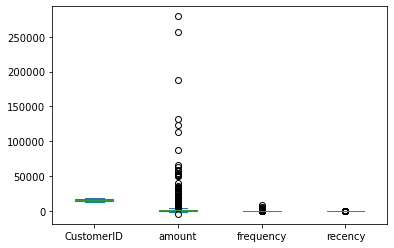

In [178]:
# Outlier Treatment 

# Two type of outliers:
    # a. Statistical Outliers  
    # b. Domain Specific Outliers
    
gf.plot(kind='box')
# amount contains outlier uqing IQR for removing outliers But , to accept them as outlier business
# domain knowledge/epertise is required 

#  Ignoring Outliers , move to next step


In [183]:
# Rescaling
import sklearn 
from sklearn.preprocessing import StandardScaler 
# instantiate a scaler 
scaler = StandardScaler()
# perform rescaling on all three columns accept CustomerID 
# fit on scaler 
gf[['amount','frequency','recency']] = scaler.fit_transform(gf[['amount','frequency','recency']])
# now mean of each scaled variable is 0 and standard deviation is 1
gf.head(3)

,CustomerID,amount,frequency,recency
0,12346.0,-0.231001,-0.391720,2.322023
1,12347.0,0.293432,0.382657,-0.893733
2,12348.0,-0.012316,-0.266959,-0.169196
